In [16]:
import pandas as pd
import numpy as np
import sys

# glm classifiers
# sgdc (loss, classifier) - ('log', 'logistic regression'), ('hinge', 'linearsvm')
from sklearn.linear_model import SGDClassifier 

# naive bayes
from sklearn.naive_bayes import GaussianNB

# nearest neighbours
from sklearn.neighbors import KNeighborsClassifier

# decision trees
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import classification_report

# datasets
from sklearn.datasets import load_iris

# linear algebra package
from numpy import linalg as LA

In [17]:
# matplotlib broken for now
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
% matplotlib inline

In [18]:
def estimator_report(true_vals, predicted, estimator="Estimator"):
    """
        Helper function to format classfication report
        
        Parameters
        ----------
        true_vals : {np.array}
            true class labels for test set
        
        predicted : {np.array}
            estimator predicted values
        
        estimator : {string}
            Estimator name - formatting purposes
    """
    print "Classification Report for %s" % estimator
    print classification_report(true_vals, predicted)
    print "\n"
   
    
def whitening_transform(train_data):
    """
        Function that determines whitenining transform
        
        Parameters
        ----------
        train_data : {np.array}
            Class data in feature 1 and 2
    """
    covar = np.cov(train_data.T, rowvar=True)
    print "Covariance Matrix: "
    print covar
    eigenval,eigenvec = LA.eig(covar)
    print "Eigenvalues: "
    print eigenval
    print "Eigenvectors: "
    print eigenvec.T

    # Compute orthornormal Whitening transform:
    normal_eigenval = np.multiply(np.power(eigenval, -0.5), np.identity(2))
    whitening = np.dot(normal_eigenval, eigenvec.T)
    print "Whitening:"
    print whitening
    return whitening


def compute_GED_distance(transform, mean, point):
    """
        Computes transformed Euclidean distance
        
        Parameters
        ----------
        transform : {np.array}
            2x2 array that contains the Whitening transform
        mean : {np.array}
            Sample mean (prototype) of dataset
        point : {np.array}
            Coordinates of point in feature space
    """
    dist = np.dot(transform, (point - mean))
    dist_T = np.dot((point - mean).T, transform.T)
    dist = np.power(np.dot(dist_T, dist), 0.5)
    return dist


def classify_point(whitening, point, prototypes):
    """
        Computes transformed Euclidean distance
        
        Parameters
        ----------
        whitening : {np.array}
            2x2 array that contains the Whitening transform
        point : {np.array}
            Coordinates of point in feature space
        prototypes : {np.array}
            Contains array of sample means (prototypes) of dataset
    """
    min_dist = sys.maxint
    clazz = 0
    for idx, p in enumerate(prototypes):
        dist = compute_GED_distance(whitening, p, point)
        if dist < min_dist:
            clazz = idx
            min_dist = dist
    return clazz

In [19]:
data = load_iris()

In [20]:
df = pd.DataFrame(data.data, columns=[data.feature_names])

In [21]:
df["target"] = data.target

In [22]:
# use numpy permutation to shuffle the data
df = df.reindex(np.random.permutation(df.index))

In [23]:
# features of interest
foi = ["petal length (cm)", "petal width (cm)"]
# foi = list(set(df.columns) - set(["target"]))

In [24]:
estimators = {"Logistic Regression": SGDClassifier(loss="log", penalty="l2"),
              "Nearest Neighbours": KNeighborsClassifier(15),
              "Naive Bayes": GaussianNB(),
              "Random Forest": RandomForestClassifier(n_estimators=100)}

In [25]:
X = df[foi].values
y = df["target"].values
X_train = X[:int(len(X)*0.7)] # retain 70% of data set for training
X_test = X[int(len(X)*0.7):]
y_train = y[:int(len(y)*0.7)]
y_test = y[int(len(y)*0.7):]

# Concatenate prior arrays for GED classifier
Z = np.c_[X, y]
Z_train = Z[:int(len(Z)*0.7)] # retain 70% of data set for training
Z_test = Z[int(len(Z)*0.7):]

In [26]:
for name, classifier in estimators.iteritems():
    # train
    classifier.fit(X_train, y_train)
    # predict
    y_pred = classifier.predict(X_test)
    estimator_report(y_test, y_pred, estimator=name)

Classification Report for Nearest Neighbours
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       1.00      0.94      0.97        16
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        45



Classification Report for Naive Bayes
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       1.00      0.94      0.97        16
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        45



Classification Report for Random Forest
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        14
          1       1.00      0.94      0.97        16
          2       0.94      1.00      0.97        15

avg / total       0.98      0.98      0.98        45



Classification Report for Logistic Regression
             precisio

In [27]:
# Retrieve sample means (prototypes) from the 3 classes in the training data
prototypes = []
for i in xrange(0, 3):
    prototypes.append(np.mean(X_train[y_train == i], axis=0))

In [28]:
# Create Whitening (orthonormal covariance) transform from training data
whitening = whitening_transform(X_train)
X_train_whitened = np.dot(whitening, X_train.T).T

# Apply Whitening transform on testing data for plotting
X_test_whitened = np.dot(whitening, X_test.T).T

Covariance Matrix: 
[[ 3.16635897  1.30030769]
 [ 1.30030769  0.57381319]]
Eigenvalues: 
[ 3.70614804  0.03402412]
Eigenvectors: 
[[ 0.92358193  0.38340112]
 [-0.38340112  0.92358193]]
Whitening:
[[ 0.47974896  0.19915536]
 [-2.07854726  5.00705029]]


In [29]:
# Classify test points
error = 0
X_new_classes = []
for point in Z_test:
    coords = point[:2]
    new_class = classify_point(whitening, coords, prototypes)
    if point[2] != new_class:
        error += 1
    X_new_classes.append(new_class)

print "ERROR:"
print error / 150.0

ERROR:
0.04


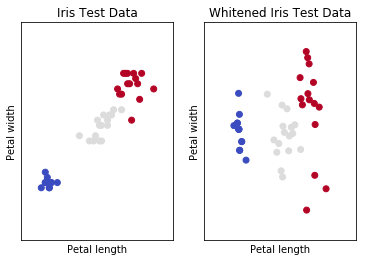

In [30]:
# Plot the non-whitened and whitened data points
plt.figure(1, figsize=(15, 6))
h = .02  # step size in the mesh
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Iris Test Data')

x_min_whitened, x_max_whitened = X_test_whitened[:, 0].min() - 1, X_test_whitened[:, 0].max() + 1
y_min_whitened, y_max_whitened = X_test_whitened[:, 1].min() - 1, X_test_whitened[:, 1].max() + 1
xx_whitened, yy_whitened = np.meshgrid(np.arange(x_min_whitened, x_max_whitened, h),
                     np.arange(y_min_whitened, y_max_whitened, h))

plt.subplot(122)
plt.scatter(X_test_whitened[:, 0], X_test_whitened[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(xx_whitened.min(), xx_whitened.max())
plt.ylim(yy_whitened.min(), yy_whitened.max())
plt.xticks(())
plt.yticks(())
plt.title('Whitened Iris Test Data')
plt.show()